<a href="https://colab.research.google.com/github/EAHITechnology/Learning-SICP/blob/master/%E6%B7%B1%E5%BA%A6%E6%A8%A1%E5%9E%8B%E8%AE%AD%E7%BB%83%E5%9F%BA%E7%A1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 背景
- 随机生成若干个均匀分布在 [-1, 1]x[-1, 1] 二维空间样本点，其中第一和第三象限的样本点标签为0，第二和第四象限的标签为1；
- 训练集样本数为30000，测试集样本数为10000；
- 使用深度学习框架训练一个神经网络模型，使得模型可以按照坐标象限预测标签。


## 构建测试数据
这里构建测试数据 40000 条，其中数据 x 为二维直角坐标系中点坐标的数组，形如：[[-3.454034,0.454532],[1.34256,9.453636]], y 为二维直角坐标系中点所在象限的标签的数组，形如：[0,1,0,1,1,0]，x 的长度和 y 的长度相同且映射结果根据数组下标一一对应。

我们用 make_blobs 方法进行数据生成，其中：
- n_samples ：样本数量，这里定义为 40000 条；
- centers：样本中心数，这里我们设置为 2，保证 y 的范围在 0 和 1 之间；
- n_features：样本纬度数，因为我们有 [x,y] 特征数据，所以特征维度是 2 ；
- random_state：随机数种子，每次测试启动相同随机样本集。

生成数据集合 :
- x：坐标点集合；
- y：标签集合。

In [110]:
from sklearn.datasets import make_blobs

# 制造一批数据
CLASS = 2
x, y = make_blobs(n_samples=40000, centers=CLASS, n_features=2,random_state=0)


## 归一化
归一化使得数据可以在一定区间上进行缩放，本质上是将数据点映射到了某个区间内，目的是为了简化计算的方式，而我们可以用归一化的方式构造数据到我们想要的区间，这里我们构造到 [-1,1] 区间内。



In [111]:
from sklearn.preprocessing import MinMaxScaler

## 归一到 [ -1，1 ]
scaler = MinMaxScaler(feature_range=[-1,1])
scaler.fit(x)
x = scaler.transform(x)

In [144]:
from matplotlib import pyplot
import numpy as np

# 画一个坐标系
def Draw_Coordinate_System():
    line_x,line_nx,line_y,line_ny=np.zeros([100,1]),np.zeros([100,1]),np.zeros([100,1]),np.zeros([100,1])

    count,xcountFl,nxcountFl,ycountFl,nycountFl=0,0.0,0.0,0.0,0.0
    while count < 100:
        line_y[count],line_x[count] = ycountFl,xcountFl
        line_ny[count],line_nx[count] = nycountFl,nxcountFl
        
        count+=1
        
        ycountFl+=0.01
        xcountFl+=0.01
        
        nycountFl-=0.01
        nxcountFl-=0.01

        tmp_x=np.zeros([100,1])
        tmp_y=np.zeros([100,1])
        pyplot.scatter(tmp_x,line_y, marker='.',c='y')
        pyplot.scatter(tmp_x,line_ny, marker='.',c='y')
        pyplot.scatter(line_x,tmp_y, marker='.',c='y')
        pyplot.scatter(line_nx,tmp_y, marker='.',c='y')

    return

## 修改数据标签
因为是随机生成标签，所以我们还需要对数据的标签进行重新规划，根据我们的题意，我们将一三象限的标签打为 0 ，二四象限标签打为 1 。并且通过 train_test_split 方法将原数据集，以 25% 的范围进行切割，生成训练集合和测试集合，保证训练数据 30000 条，测试数据 10000 条。

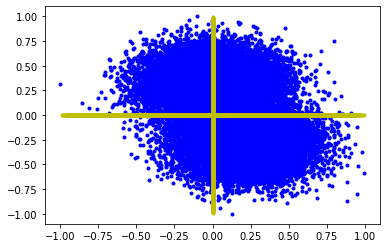

In [145]:
from sklearn.model_selection import train_test_split

## 确定象限
for i in range(len(x)):
    if x[i][0]>0 and x[i][1]>0 :
        y[i]=0
    elif x[i][0]>0 and x[i][1]<0 :
        y[i]=1
    elif x[i][0]<0 and x[i][1]>0 :
        y[i]=1
    else :
        y[i]=0

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

train_show_x,train_show_y = x_train[:,0],x_train[:,1]
pyplot.scatter(train_show_x,train_show_y, marker='.',c='b') 

Draw_Coordinate_System()

pyplot.show()


 ## 构建神经网络
 我们开始构建神经网络，这里采用用 Sequential() 顺序模型堆叠了三层神经网络，一个输入层，一个隐藏层，一个输出层；其中输入层我们 Dense 指定神经元数为 2，输入数据维度为 2，激活函数为 tanh ，隐藏层神经元数为 2，激活函数为 tanh，输出层激活函数为 sigmoid 二分模型，得到趋于一个标签的概率。

In [146]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(units=2, input_dim=2,activation="tanh"))
model.add(Dense(units=4, activation="tanh"))
model.add(Dense(units=1, activation="sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2)                 6         
                                                                 
 dense_10 (Dense)            (None, 4)                 12        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


## 编译模型
这里用 compile 进行模型编译，其中：
- loss ：损失函数，得到损失率，其结果是所有预测点实际结果和拟合曲线点的距离的计算，损失率越低预测数据和实际曲线越贴合；
- optimizer：优化器，这里使用 adam 优化器，并且对 lr 进行设置；
- mertics：accuracy 代表对训练过程的打印。

In [147]:
import keras

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.adam_v2.Adam(lr=1e-3),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 训练模型
编译之后我们对模型进行训练，在这之前我们设置自动降低学习率，因为像两纬度模型，在我之前训练时经常出现过拟合的情况，所以在尝试梯度下降的过程中几个 epoch 找不到最优解那么就需要降低学习率，将寻找最优解的步长放大。
fit 方法：
- x：训练集；
- Y：标签集；
- epoch：训练 batch；
- callback：回调函数，可以设置每个 epoch 后的行为，可以设置如下的自动学习率降低。

In [149]:
from keras.callbacks import ReduceLROnPlateau


## 自动设置，连续5个epoch loss不降低，就降低lr
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, mode='auto')

history = model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=2, callbacks=[reduce_lr])
print(history.history.keys())

Epoch 1/50
469/469 - 1s - loss: 0.0514 - accuracy: 0.9820 - lr: 0.0010 - 614ms/epoch - 1ms/step
Epoch 2/50
469/469 - 1s - loss: 0.0499 - accuracy: 0.9823 - lr: 0.0010 - 583ms/epoch - 1ms/step
Epoch 3/50
469/469 - 1s - loss: 0.0485 - accuracy: 0.9832 - lr: 0.0010 - 613ms/epoch - 1ms/step
Epoch 4/50
469/469 - 1s - loss: 0.0471 - accuracy: 0.9835 - lr: 0.0010 - 609ms/epoch - 1ms/step
Epoch 5/50
469/469 - 1s - loss: 0.0458 - accuracy: 0.9840 - lr: 0.0010 - 591ms/epoch - 1ms/step
Epoch 6/50
469/469 - 1s - loss: 0.0445 - accuracy: 0.9847 - lr: 0.0010 - 613ms/epoch - 1ms/step
Epoch 7/50
469/469 - 1s - loss: 0.0433 - accuracy: 0.9851 - lr: 0.0010 - 598ms/epoch - 1ms/step
Epoch 8/50
469/469 - 1s - loss: 0.0421 - accuracy: 0.9852 - lr: 0.0010 - 613ms/epoch - 1ms/step
Epoch 9/50
469/469 - 1s - loss: 0.0409 - accuracy: 0.9857 - lr: 0.0010 - 608ms/epoch - 1ms/step
Epoch 10/50
469/469 - 1s - loss: 0.0398 - accuracy: 0.9867 - lr: 0.0010 - 585ms/epoch - 1ms/step
Epoch 11/50
469/469 - 1s - loss: 0.0388

## 训练正确率和损失函数梯度下降展示

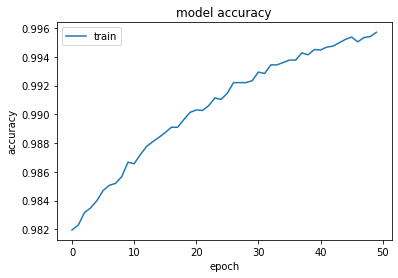

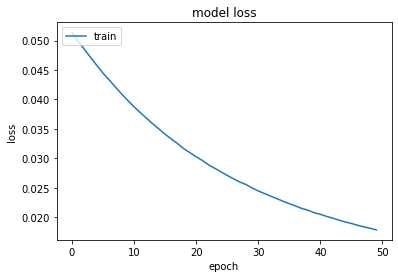

In [150]:
# Summarize history for accuracy
pyplot.plot(history.history['accuracy'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left') 
pyplot.show()

# Summarize history for loss 
pyplot.plot(history.history['loss']) 
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left') 
pyplot.show()

## 模型预测
到这里我们训练完成可以调用模型，拿出我们之前构造的测试数据 10000 条。放入模型中，我们就得到了每个点趋于标签为 1 的概率的集合，接下来我们就需要设置一个阈值，eg: 0.8，阈值可以根据上一步训练最后的正确率来进行设置，大于这个值的元素即为 1 标签其余为 0 标签。同时用 accuracy_score 方法对比测试集合结果和预测结果，得到我们本次训练的正确率。

In [151]:
from sklearn import metrics

predict_x = model.predict(x_test)
_y_pred = np.array([1 if i[0]>0.8 else 0 for i in predict_x])
_y_test = np.array([i for i in y_test])

bad_p,good_p = [[]],[[]]
for idx in range(len(_y_pred)):
    if _y_pred[idx] != _y_test[idx]:
        bad_p.append(x_test[idx])
    else :
        good_p.append(x_test[idx])

good_p=good_p[1:]
good_p=np.array(good_p)

bad_p=bad_p[1:]
bad_p=np.array(bad_p)

print("*****")
print("正确率:%f" % metrics.accuracy_score(_y_test, _y_pred))

*****
正确率:0.988900


## 展示
点向内并且越接近 y=0/x=0 颜色越深，代表概率越不确定

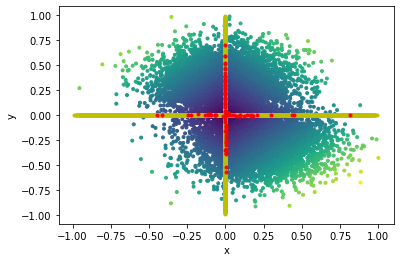

In [157]:
good_xs = good_p[:,0]
good_ys = good_p[:,1]

bad_xs = bad_p[:,0]
bad_ys = bad_p[:,1]


pyplot.xlabel('x')
pyplot.ylabel('y')


pyplot.scatter(good_xs,good_ys,c=(abs(good_xs)+abs(good_ys))*2,marker='.') 

Draw_Coordinate_System()

pyplot.scatter(bad_xs,bad_ys,c='r',marker='.') 



pyplot.show()
